In [1]:
from utils.dataloader import H5Dataset
from utils.EarlyStopping import EarlyStopping

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report
from tqdm import tqdm


In [2]:
num_classes = 4
k_folds = 5
num_epochs = 5
batch_size = 32
patience = 2


# Caminho para os arquivos h5
h5_files = [
    "h5_files/GunshotForensic_feature.h5",
    "h5_files/HEAR_Train_feature.h5",
    "h5_files/MIVIA_test_feature.h5",
    "h5_files/MIVIA_train_feature.h5",
    "h5_files/SESA_feature.h5",
    "h5_files/vsd_clipped_feature.h5",
    "h5_files/Audioset_feature.h5",
]

# Carregando os dataloaders
dataset = H5Dataset(h5_files, exclude_classes=[4, 5, 6], n_splits=k_folds)
dataloaders = dataset.get_k_fold_data_loaders(batch_size=batch_size, num_workers=4)

In [3]:
from torchvision.models import ResNet101_Weights


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

criterion = nn.CrossEntropyLoss()

# Configurando o TensorBoard
writer = SummaryWriter()

cuda


In [4]:
# Loop de treinamento
for fold, (train_loader, val_loader) in enumerate(dataloaders):
    print(f"Starting fold {fold + 1}/{len(dataloaders)}")

    # Ajustando a ResNet101
    model = models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
    # model = models.resnet101()

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(
        num_ftrs, num_classes
    )  # ajustar a última camada para 6 classes
    model.conv1 = nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )  # ajustar a primeira camada para 1 canal
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True, fold=fold)

    for epoch in range(num_epochs):  # número de épocas
        print(f"Starting epoch {epoch + 1}/{num_epochs}")

        # Treinamento
        model.train()
        running_loss_train = 0.0
        running_corrects_train = 0
        for i, (inputs, labels) in tqdm(
            enumerate(train_loader), total=len(train_loader)
        ):
            inputs = inputs.unsqueeze(1).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects_train += torch.sum(preds == labels.data)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss_train += loss.item() * inputs.size(0)

        epoch_loss_train = running_loss_train / len(train_loader.dataset)
        epoch_acc_train = running_corrects_train.double() / len(train_loader.dataset)

        # Validação
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader):
                inputs = inputs.unsqueeze(1).to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                running_corrects_val += torch.sum(preds == labels.data)
                loss = criterion(outputs, labels)

                running_loss_val += loss.item() * inputs.size(0)

                all_labels.extend(labels.data.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        epoch_loss_val = running_loss_val / len(val_loader.dataset)
        epoch_acc_val = running_corrects_val.double() / len(val_loader.dataset)

        report = classification_report(all_labels, all_preds, output_dict=True)

        print(f"Train Loss: {epoch_loss_train:.4f} Train Acc: {epoch_acc_train:.4f}")
        print(
            f"Validation Loss: {epoch_loss_val:.4f} Validation Acc: {epoch_acc_val:.4f}"
        )

        f1_scores = {}
        precisions = {}
        recalls = {}
        for class_index in range(num_classes):
            f1_scores[f"class_{class_index}"] = report[str(class_index)]["f1-score"]
            precisions[f"class_{class_index}"] = report[str(class_index)]["precision"]
            recalls[f"class_{class_index}"] = report[str(class_index)]["recall"]

        writer.add_scalars(f"F1 scores_{fold}", f1_scores, epoch)
        writer.add_scalars(f"Precisions_{fold}", precisions, epoch)
        writer.add_scalars(f"Recalls_{fold}", recalls, epoch)

        writer.add_scalar(f"training loss_{fold}", epoch_loss_train, epoch)
        writer.add_scalar(f"training accuracy_{fold}", epoch_acc_train, epoch)
        writer.add_scalar(f"validation loss_{fold}", epoch_loss_val, epoch)
        writer.add_scalar(f"validation accuracy_{fold}", epoch_acc_val, epoch)

        early_stopping(epoch_loss_val, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    print(f"Finished fold {fold + 1}/{len(dataloaders)}")

# Salvando o modelo treinado
torch.save(model.state_dict(), f"models/model_resnet101_{k_folds}_Folds.pth")

# Fechando o TensorBoard writer
writer.close()

print("Finished Training")

Starting fold 1/5
Starting epoch 1/5


100%|██████████| 563/563 [01:22<00:00,  6.84it/s] 


Train Loss: 0.6712 Train Acc: 0.7118
Validation Loss: 0.5758 Validation Acc: 0.7386
Validation loss decreased (inf --> 0.575764).  Saving model ...
Starting epoch 2/5


100%|██████████| 563/563 [01:22<00:00,  6.82it/s] 


Train Loss: 0.5126 Train Acc: 0.7778
Validation Loss: 0.5268 Validation Acc: 0.7754
Validation loss decreased (0.575764 --> 0.526834).  Saving model ...
Starting epoch 3/5


100%|██████████| 563/563 [01:25<00:00,  6.58it/s] 


Train Loss: 0.4546 Train Acc: 0.8066
Validation Loss: 0.4966 Validation Acc: 0.7877
Validation loss decreased (0.526834 --> 0.496615).  Saving model ...
Starting epoch 4/5


100%|██████████| 563/563 [01:25<00:00,  6.62it/s] 


Train Loss: 0.4134 Train Acc: 0.8246
Validation Loss: 0.4895 Validation Acc: 0.7954
Validation loss decreased (0.496615 --> 0.489505).  Saving model ...
Starting epoch 5/5


100%|██████████| 563/563 [01:25<00:00,  6.62it/s] 


Train Loss: 0.3798 Train Acc: 0.8391
Validation Loss: 0.6061 Validation Acc: 0.7623
EarlyStopping counter: 1 out of 2
Finished fold 1/5
Starting fold 2/5
Starting epoch 1/5


100%|██████████| 563/563 [01:24<00:00,  6.66it/s] 


Train Loss: 0.6527 Train Acc: 0.7173
Validation Loss: 0.6061 Validation Acc: 0.7289
Validation loss decreased (inf --> 0.606123).  Saving model ...
Starting epoch 2/5


100%|██████████| 563/563 [01:24<00:00,  6.66it/s] 


Train Loss: 0.4867 Train Acc: 0.7915
Validation Loss: 0.7354 Validation Acc: 0.6650
EarlyStopping counter: 1 out of 2
Starting epoch 3/5


100%|██████████| 563/563 [01:27<00:00,  6.46it/s] 


Train Loss: 0.4233 Train Acc: 0.8212
Validation Loss: 0.4402 Validation Acc: 0.8155
Validation loss decreased (0.606123 --> 0.440154).  Saving model ...
Starting epoch 4/5


100%|██████████| 563/563 [01:26<00:00,  6.51it/s] 


Train Loss: 0.3759 Train Acc: 0.8437
Validation Loss: 0.4367 Validation Acc: 0.8203
Validation loss decreased (0.440154 --> 0.436677).  Saving model ...
Starting epoch 5/5


100%|██████████| 563/563 [01:24<00:00,  6.66it/s] 


Train Loss: 0.3422 Train Acc: 0.8578
Validation Loss: 0.4125 Validation Acc: 0.8354
Validation loss decreased (0.436677 --> 0.412510).  Saving model ...
Finished fold 2/5
Starting fold 3/5
Starting epoch 1/5


100%|██████████| 563/563 [01:26<00:00,  6.48it/s] 


Train Loss: 0.6348 Train Acc: 0.7197
Validation Loss: 0.7222 Validation Acc: 0.7115
Validation loss decreased (inf --> 0.722246).  Saving model ...
Starting epoch 2/5


100%|██████████| 563/563 [01:27<00:00,  6.45it/s] 


Train Loss: 0.4855 Train Acc: 0.7873
Validation Loss: 0.6465 Validation Acc: 0.7404
Validation loss decreased (0.722246 --> 0.646531).  Saving model ...
Starting epoch 3/5


100%|██████████| 563/563 [01:26<00:00,  6.50it/s] 


Train Loss: 0.4353 Train Acc: 0.8118
Validation Loss: 0.5900 Validation Acc: 0.7813
Validation loss decreased (0.646531 --> 0.590042).  Saving model ...
Starting epoch 4/5


100%|██████████| 563/563 [01:27<00:00,  6.44it/s] 


Train Loss: 0.3926 Train Acc: 0.8306
Validation Loss: 0.6869 Validation Acc: 0.7294
EarlyStopping counter: 1 out of 2
Starting epoch 5/5


100%|██████████| 563/563 [01:26<00:00,  6.48it/s] 


Train Loss: 0.3583 Train Acc: 0.8469
Validation Loss: 0.6080 Validation Acc: 0.7705
EarlyStopping counter: 2 out of 2
Early stopping
Finished fold 3/5
Starting fold 4/5
Starting epoch 1/5


100%|██████████| 563/563 [01:27<00:00,  6.45it/s] 


Train Loss: 0.6614 Train Acc: 0.7111
Validation Loss: 0.6134 Validation Acc: 0.7767
Validation loss decreased (inf --> 0.613352).  Saving model ...
Starting epoch 2/5


100%|██████████| 563/563 [01:27<00:00,  6.45it/s] 


Train Loss: 0.5068 Train Acc: 0.7815
Validation Loss: 0.5216 Validation Acc: 0.8065
Validation loss decreased (0.613352 --> 0.521569).  Saving model ...
Starting epoch 3/5


100%|██████████| 563/563 [01:27<00:00,  6.45it/s] 


Train Loss: 0.4427 Train Acc: 0.8126
Validation Loss: 0.7066 Validation Acc: 0.8278
EarlyStopping counter: 1 out of 2
Starting epoch 4/5


100%|██████████| 563/563 [01:27<00:00,  6.44it/s] 


Train Loss: 0.3861 Train Acc: 0.8388
Validation Loss: 0.7949 Validation Acc: 0.7522
EarlyStopping counter: 2 out of 2
Early stopping
Finished fold 4/5
Starting fold 5/5
Starting epoch 1/5


100%|██████████| 563/563 [01:24<00:00,  6.66it/s] 


Train Loss: 0.6144 Train Acc: 0.7343
Validation Loss: 0.9787 Validation Acc: 0.6450
Validation loss decreased (inf --> 0.978715).  Saving model ...
Starting epoch 2/5


100%|██████████| 563/563 [01:26<00:00,  6.54it/s] 


Train Loss: 0.4633 Train Acc: 0.8015
Validation Loss: 0.9183 Validation Acc: 0.6774
Validation loss decreased (0.978715 --> 0.918286).  Saving model ...
Starting epoch 3/5


100%|██████████| 563/563 [01:24<00:00,  6.64it/s] 


Train Loss: 0.4102 Train Acc: 0.8250
Validation Loss: 0.9340 Validation Acc: 0.7020
EarlyStopping counter: 1 out of 2
Starting epoch 4/5


100%|██████████| 563/563 [01:25<00:00,  6.61it/s] 


Train Loss: 0.3690 Train Acc: 0.8436
Validation Loss: 1.0543 Validation Acc: 0.6938
EarlyStopping counter: 2 out of 2
Early stopping
Finished fold 5/5
Finished Training


In [5]:
import numpy as np
import os

# Dicionário para armazenar os relatórios de classificação para cada fold
classification_reports = []

# Caminho para a pasta com os modelos
model_folder = "models/checkpoint"

# Loop através de cada fold
for fold in range(k_folds):
    # Carregando o modelo
    model_path = os.path.join(model_folder, f"checkpoint_{fold}.pth")
    model.load_state_dict(torch.load(model_path))

    # Pegando o dataloader de teste para este fold
    _, test_loader = dataloaders[fold]

    # Avaliando o modelo neste fold
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1).to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Gerando o relatório de classificação para este fold
    report = classification_report(all_labels, all_preds, output_dict=True)
    classification_reports.append(report)

# Calculando a média das métricas para cada classe em todos os folds
avg_metrics = {
    class_: {"precision": 0, "recall": 0, "f1-score": 0, "support": 0}
    for class_ in range(num_classes)
}
for report in classification_reports:
    for class_ in range(num_classes):
        avg_metrics[class_]["precision"] += report[str(class_)]["precision"]
        avg_metrics[class_]["recall"] += report[str(class_)]["recall"]
        avg_metrics[class_]["f1-score"] += report[str(class_)]["f1-score"]
        avg_metrics[class_]["support"] += report[str(class_)]["support"]

for class_ in range(num_classes):
    avg_metrics[class_]["precision"] /= k_folds
    avg_metrics[class_]["recall"] /= k_folds
    avg_metrics[class_]["f1-score"] /= k_folds
    avg_metrics[class_]["support"] = np.round(
        avg_metrics[class_]["support"] / k_folds
    ).astype

In [6]:
annotation_dict = {
    0: "Nada",
    1: "Grito",
    2: "Violência Física",
    3: "Tiro",
    4: "Explosão",
    5: "Grito de Esforço",
}

for class_ in range(num_classes):
    print(f"Class: {annotation_dict[class_]}")
    print("Precision\tRecall\tF1-Score\tSupport")
    print(
        "{:.4f}\t\t{:.4f}\t{:.4f}\t\t{}".format(
            avg_metrics[class_]["precision"],
            avg_metrics[class_]["recall"],
            avg_metrics[class_]["f1-score"],
            avg_metrics[class_]["support"](int),
        )
    )
    print("===============================================")

Class: Nada
Precision	Recall	F1-Score	Support
0.8108		0.7984	0.8027		9154
Class: Grito
Precision	Recall	F1-Score	Support
0.6249		0.5719	0.5668		1457
Class: Violência Física
Precision	Recall	F1-Score	Support
0.8242		0.8180	0.8147		6124
Class: Tiro
Precision	Recall	F1-Score	Support
0.8302		0.6907	0.7282		1259


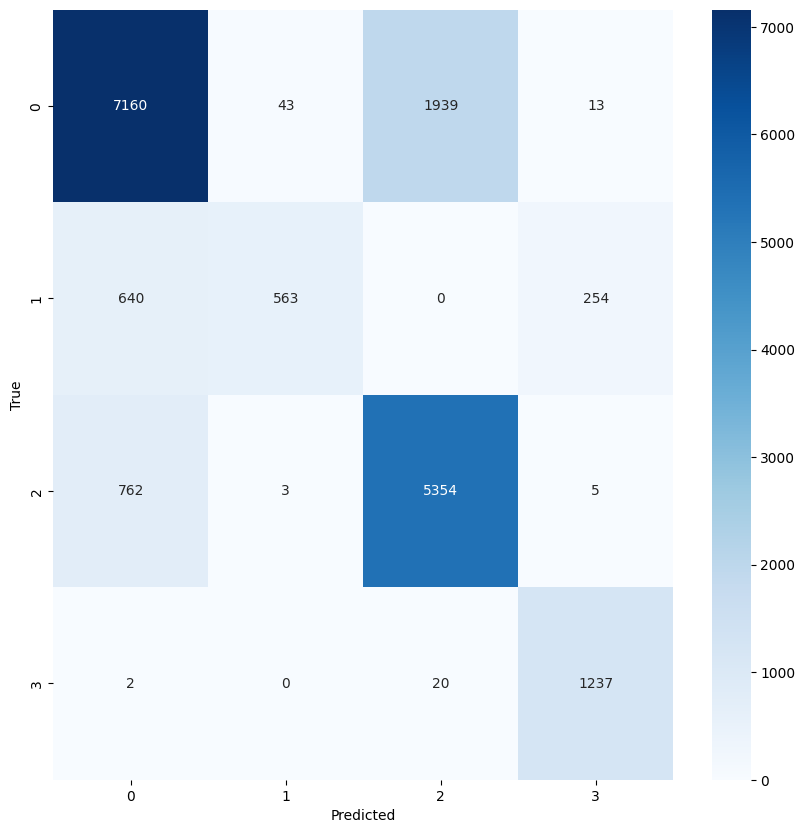

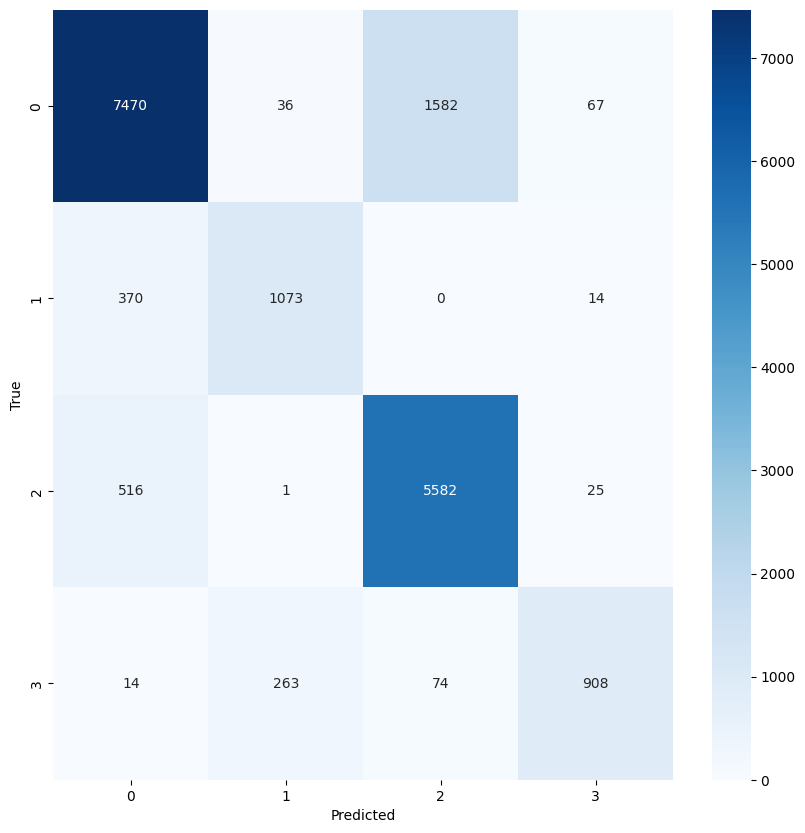

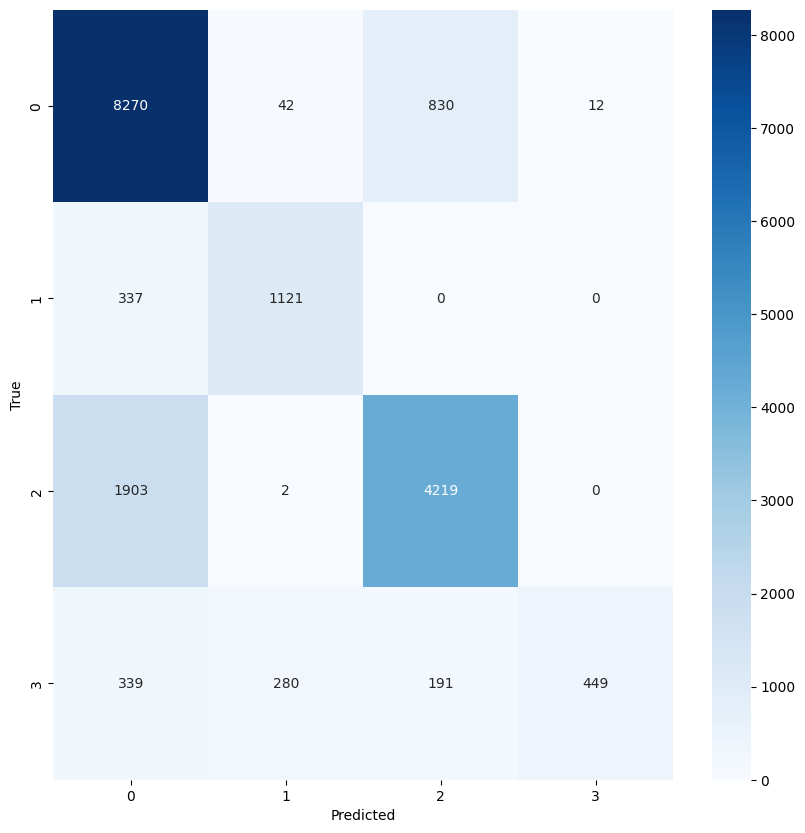

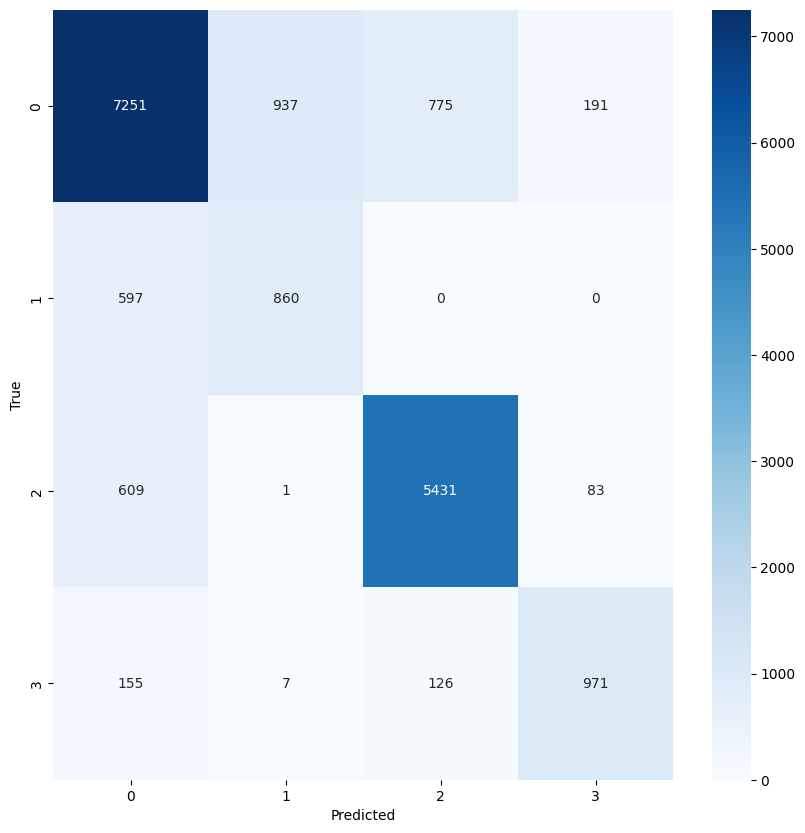

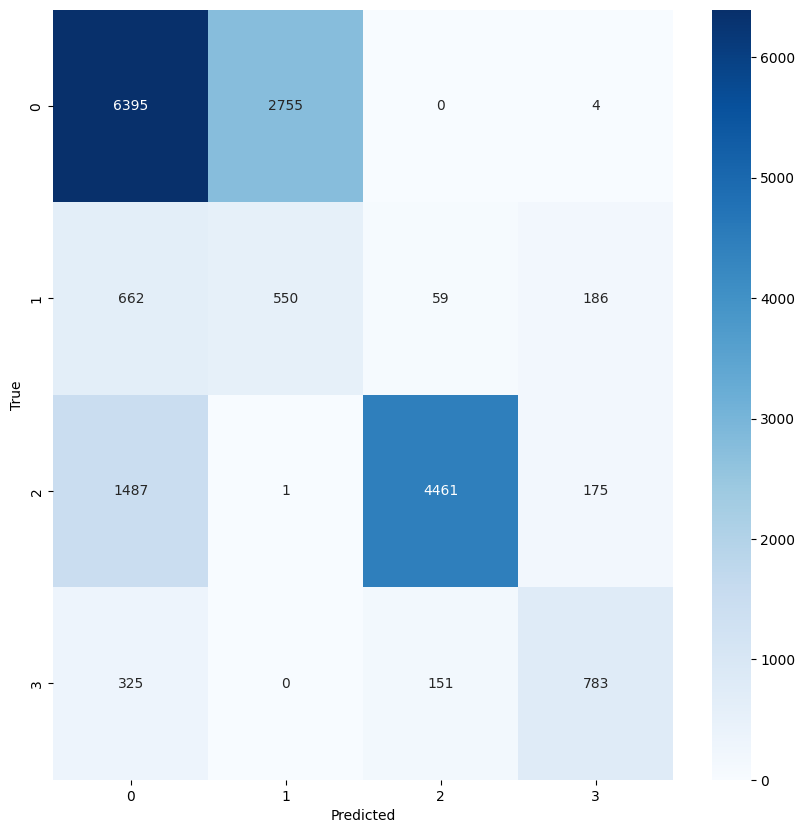

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

# Dicionário para armazenar os relatórios de classificação para cada fold
classification_reports = []

# Caminho para a pasta com os modelos
model_folder = "models/checkpoint"

# Loop através de cada fold
for fold in range(k_folds):
    # Carregando o modelo
    model_path = os.path.join(model_folder, f"checkpoint_{fold}.pth")
    model.load_state_dict(torch.load(model_path))

    # Pegando o dataloader de teste para este fold
    _, test_loader = dataloaders[fold]

    # Avaliando o modelo neste fold
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1).to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()